In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense,Embedding, Concatenate, TimeDistributed
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

2021-11-19 11:29:02.572108: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-19 11:29:02.572131: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


|# Read the Data and Create DF

In [2]:
text = open('data/pol.txt').read().split('\n')
print(len(text))

41179


In [3]:
language_df = pd.DataFrame(columns=['en', 'pl'])
en_list = []
pl_list = []
for sentences in text:
  try:
    sentence = sentences.split('\t')
    pl_list.append(sentence[1])
    en_list.append(sentence[0])
  except:
    continue

language_df['en'] = en_list
language_df['pl'] = pl_list
language_df.head()

,en,pl
0,Go.,Idź.
1,Hi.,Cześć.
2,Run!,Uciekaj!
3,Run.,Biegnij.
4,Run.,Uciekaj.


# Data Cleaning

In [4]:
def clean_text(text):
    # to lower case and remove spaces and end and start
    text = text.lower().strip()
    # remove digits
    text = re.sub('\d', '', text)
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

language_df['en'] = language_df['en'].apply(clean_text)
language_df['pl'] = language_df['pl'].apply(clean_text)
language_df.head()

,en,pl
0,go,idź
1,hi,cześć
2,run,uciekaj
3,run,biegnij
4,run,uciekaj


In [5]:
# putting START and END in polish sentences
language_df['pl'] = language_df['pl'].apply(lambda text: "START "+text+" END")
print("English Sentence: " + language_df['en'].iloc[0])
print("Polish Sentence: " + language_df['pl'].iloc[0])

English Sentence: go
Polish Sentence: START idź END


# Data Preparation for Model Building

In [6]:
import numpy as np

# train test split
x = language_df['en']
y = language_df['pl']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

# determine the maximum length of sentence
def determine_sentence_len(data):
    lenghts = [len(x.split(' ')) for x in data]
    return round(np.mean(lenghts) + 2 * np.std(lenghts))
max_len = max(determine_sentence_len(x_train), determine_sentence_len(y_train))
max_len

12

In [7]:
# tokenization
en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(x_train)
vocab_size_en = len(en_tokenizer.word_index) + 1

x_train = en_tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen=max_len, padding='post')
x_test = en_tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen=max_len, padding='post')

pl_tokenizer = Tokenizer()
pl_tokenizer.fit_on_texts(y_train)
vocab_size_pl = len(pl_tokenizer.word_index) + 1

y_train = pl_tokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_len, padding='post')
y_test = pl_tokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen=max_len, padding='post')
x_train[0], y_train[0]

(array([  33, 1589,  848,    0,    0,    0,    0,    0,    0,    0,    0,
           0], dtype=int32),
 array([   1, 1623, 2112,    2,    0,    0,    0,    0,    0,    0,    0,
           0], dtype=int32))

# Define Model

## Encoder

In [8]:
encoder_input = Input(shape=(max_len, ))
encoder_embedding = Embedding(vocab_size_en, 500, trainable=True)(encoder_input)

# LSTM with states
encoder_lstm_1 = LSTM(512, return_sequences=True)(encoder_embedding)
encoder_lstm_2 = LSTM(512, return_sequences=True)(encoder_lstm_1)
encoder_output, state_h, state_c = LSTM(512, return_sequences=True, return_state=True)(encoder_lstm_2)

2021-11-19 11:29:07.132762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-19 11:29:07.133512: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-19 11:29:07.133640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-11-19 11:29:07.133747: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-11-19 11:29:07.133867: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

## Decoder

In [9]:
decoder_input = Input(shape=(None, ))
decoder_embedding = Embedding(vocab_size_pl, 500, trainable=True)(decoder_input)

# decoder LSTM on encoder states
decoder_lstm_output, decoder_fwd_state, decoder_bwd_state, = LSTM(512, return_sequences=True, return_state=True)(decoder_embedding, initial_state=[state_h, state_c])

decoder_output = Dense(vocab_size_pl, activation='softmax')(decoder_lstm_output)

2021-11-19 11:29:08.134782: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 40644000 exceeds 10% of free system memory.
2021-11-19 11:29:08.150299: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 40644000 exceeds 10% of free system memory.
2021-11-19 11:29:08.161573: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 40644000 exceeds 10% of free system memory.
2021-11-19 11:29:08.424374: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 41619456 exceeds 10% of free system memory.
2021-11-19 11:29:08.435290: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 41619456 exceeds 10% of free system memory.


## Define Model

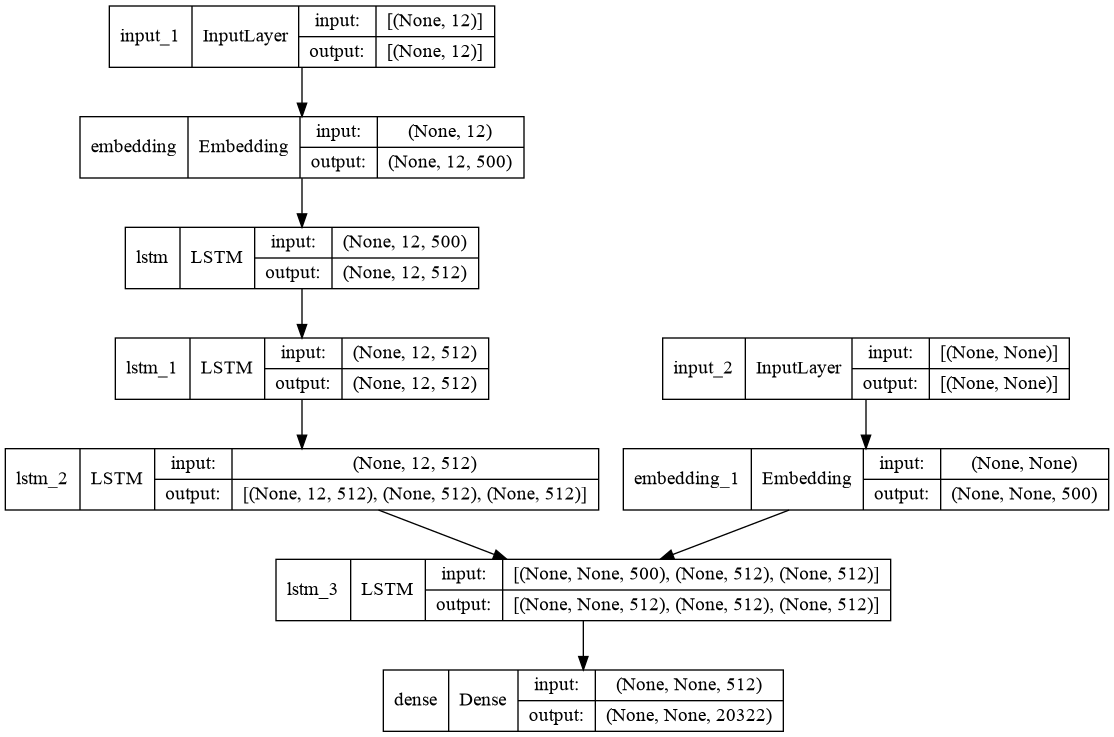

In [10]:
model = Model([encoder_input, decoder_input], decoder_output)
plot_model(model, show_shapes=True)

In [11]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit([x_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:],
                    epochs=50,
                    batch_size=64,
                    validation_data = ([x_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/50
 15/580 [..............................] - ETA: 7:41 - loss: 5.2364 - accuracy: 0.4485     

KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()